<img src="https://s3.amazonaws.com/datascienceheroes.com/EDV/360_banner_python.png" width="400px">

# Escuela de Datos Vivos
## LAB P.E.3: Creación de árboles de decisión

Creado por Pablo Casas | https://escueladedatosvivos.ai    

## Ejercicios

Crear un decision tree para los datos de credit bank 'data/bank_2.csv'

1) Predecir `deposit` en función de `age`, `loan`, `education` y `job`

_Nota: Si el árbol no se dibuja, es porque es muy restrictivo, tienen que hacerlo menos restrictivo modificando los parámetros._

2) ¿Cuál es la variable más importante?

3) ¿Cuales son las primeras 2 reglas? Escribirlas y validarlas haciendo un filtro con pandas query.

4) Hacer un árbol con 3 niveles, y otro con 10, explorarlo.

5) Validar la tasa de acierto de al menos 2 reglas con datos de testing, tiene que dar parecido para poder decir que el modelo aprendió el patrón general (y no hizo overfitting)

6) Redactar un pequeño párrafo indicando que información (insights) se puede obtener de los distintos modelos creados.

## Solución

In [307]:
# Librerías que vamos a utilizar

import pydotplus
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from IPython.display import Image  
from sklearn.tree import export_graphviz
from funpymodeling.exploratory import status, profiling_num, freq_tbl

#### 1) Cargamos los datos

In [74]:
data = pd.read_csv("../data/bank_2.csv", sep=";")

print(f"Cantidad de registros: {data.shape[0]}")
print(f"Cantidad de variables: {data.shape[1]}")

Cantidad de registros: 11162
Cantidad de variables: 17


Definimos las variables independientes y la variable a predecir

In [75]:
variables_x = ['age', 'loan', 'education', 'job']

In [76]:
data_x = data[variables_x]

In [77]:
data_y = data['deposit']

Analizamos los variables independientes tomando una muestra aleatoria de ellos

In [78]:
data_x.sample(5)

,age,loan,education,job
9248,57,no,primary,retired
9649,48,yes,tertiary,self-employed
3912,75,no,primary,retired
1864,59,yes,tertiary,retired
1521,32,no,tertiary,management


Analizamos el estado de esos datos

In [79]:
status(data_x)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,age,0,0.0,0,0.0,79,int64
1,loan,0,0.0,0,0.0,2,object
2,education,0,0.0,0,0.0,4,object
3,job,0,0.0,0,0.0,12,object


Vemos que no hay valores nulos ni cero. Hay 3 variables categóricas y una numérica, en ningún caso están mal declaradas.

Analizamos la variable a predecir

In [80]:
data_y.sample(5)

4119     yes
5519      no
10654     no
7363      no
3412     yes
Name: deposit, dtype: object

In [81]:
status(data_y)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,deposit,5,0.000448,0,0.0,2,object


Vemos que hay 5 valores nulos, que representan el 0.04% de los registros. Los vamos a eliminar.

In [92]:
indexs = data_y[data_y.isnull()].index
data_y_sinnulls = data_y.drop(indexs, axis=0)

In [93]:
status(data_y_sinnulls)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,deposit,0,0.0,0,0.0,2,object


In [98]:
print(f"Registros sin borrar nulos = {data_y.shape[0]}")
print(f"Registros al borrar nulos = {data_y_sinnulls.shape[0]}")

Registros sin borrar nulos = 11162
Registros al borrar nulos = 11157


Borramos esos mismos registros para los datos de las variables independientes

In [99]:
data_x_sinnulls = data_x.drop(indexs, axis=0)
print(f"Registros sin borrar nulos = {data_x.shape[0]}")
print(f"Registros al borrar nulos = {data_x_sinnulls.shape[0]}")

Registros sin borrar nulos = 11162
Registros al borrar nulos = 11157


Discretizamos la variable 'age'. La inspeccionamos

In [102]:
profiling_num(data_x_sinnulls['age'])

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,age,43.229901,211.183354,4.885122,22.0,26.0,32.0,39.0,49.0,61.0,77.0


In [105]:
data_x_sinnulls['age'].describe()

count    11157.000000
mean        43.229901
std        211.183354
min          2.000000
25%         32.000000
50%         39.000000
75%         49.000000
max      22312.000000
Name: age, dtype: float64

La variable "age" toma valores entre 2 y 22312, siendo 43 el valor medio, y valores mayores a 61 pueden ser considerados como outliers. Vemos que hay outliers para valores mínimos (edad de 2) y valores máximos (edad mayor a 20000). Dividimos esta variable en 5 categorías.

In [107]:
data_x_sinnulls['age_cat'], bins = pd.qcut(data_x_sinnulls['age'], q=5, retbins=True)

In [108]:
status(data_x_sinnulls)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,age,0,0.0,0,0.0,79,int64
1,loan,0,0.0,0,0.0,2,object
2,education,0,0.0,0,0.0,4,object
3,job,0,0.0,0,0.0,12,object
4,age_cat,0,0.0,0,0.0,5,category


In [110]:
freq_tbl(data_x_sinnulls['age_cat'])

,age_cat,frequency,percentage,cumulative_perc
0,"(1.999, 31.0]",2504,0.224433,0.224433
1,"(31.0, 36.0]",2298,0.205969,0.430402
2,"(42.0, 52.0]",2297,0.205880,0.636282
3,"(52.0, 22312.0]",2073,0.185803,0.822085
4,"(36.0, 42.0]",1985,0.177915,1.000000


Borramos la variable 'age' pues ya la pasamos a categórica

In [112]:
data_x_sinnulls = data_x_sinnulls.drop(['age'], axis=1)

Hacemos la conversión a variables numéricas con one-hot encoding

In [114]:
data_x_sin_red = pd.get_dummies(data_x_sinnulls, dummy_na=True, drop_first=True)

vars_to_drop = status(data_x_sin_red).query("unique==1")['variable']

data_x_final = data_x_sin_red.drop(vars_to_drop, axis=1)

In [117]:
data_x_final.sample(5)

,loan_yes,education_secondary,education_tertiary,education_unknown,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,"age_cat_(31.0, 36.0]","age_cat_(36.0, 42.0]","age_cat_(42.0, 52.0]","age_cat_(52.0, 22312.0]"
7669,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
7940,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
6121,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
703,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7106,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [118]:
status(data_x_final)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,loan_yes,0,0.0,9698,0.869230,2,uint8
1,education_secondary,0,0.0,5682,0.509277,2,uint8
2,education_tertiary,0,0.0,7470,0.669535,2,uint8
3,education_unknown,0,0.0,10660,0.955454,2,uint8
4,job_blue-collar,0,0.0,9213,0.825760,2,uint8
5,job_entrepreneur,0,0.0,10829,0.970601,2,uint8
6,job_housemaid,0,0.0,10883,0.975441,2,uint8
7,job_management,0,0.0,8592,0.770099,2,uint8
8,job_retired,0,0.0,10380,0.930358,2,uint8
9,job_self-employed,0,0.0,10752,0.963700,2,uint8


Hacemos el mismo one-hot encoding para la variable a predecir

In [116]:
data_y_sin_red = pd.get_dummies(data_y_sinnulls, drop_first=True)

vars_to_drop = status(data_y_sin_red).query("unique==1")['variable']

data_y_final = data_y_sin_red.drop(vars_to_drop, axis=1)

In [119]:
data_y_final.sample(5)

,yes
6346,0
6107,0
8843,0
5781,0
4397,1


In [120]:
status(data_y_final)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,yes,0,0.0,5868,0.525948,2,uint8


Creamos el árbol de decisión

In [132]:
model = tree.DecisionTreeClassifier(
    max_depth= 2,
    min_samples_leaf=50,
    random_state=0) 

Hemos creado un árbol con los siguientes parámetros:

- `max_depth=2` Consideramos 3 niveles (0, 1, 2) para el árbol
- `min_samples_leaf=50` El número mínimo de muestras para que un registro esté en un leaf node (nodo que no se divide) es 50
- `random_state=0` Agregamos una semilla para reproducir resultados

Entrenamos al modelo

In [135]:
model.fit(data_x_final, data_y_final)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, random_state=0)

Graficamos el árbol de decisión

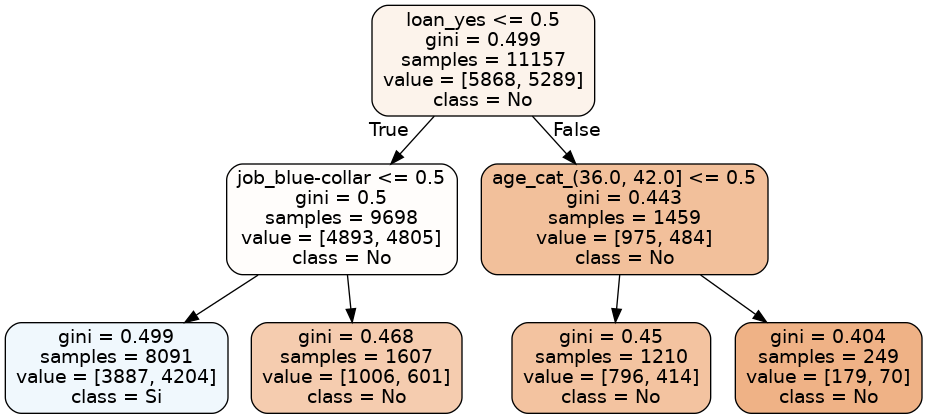

In [136]:
def plot_tree(model, data_x):
    dot_data = tree.export_graphviz(model, 
                                    out_file=None, 
                                    feature_names=list(data_x.columns.values), 
                                    class_names=['No', 'Si'], 
                                    rounded=True, 
                                    filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

plot_tree(model, data_x_final)

#### 2) Determinación de la variable más importante

A partir del gráfico podemos observar que la variable más importante es "loan_yes" y aparece la pregunta "loan_yes <= 0.5" (es decir, "tiene prestamo = falso"). Esta pregunta se hace en el modo raíz en el cual las muestras son samples=11157 es decir, el número total de muestras, y los valores value=[5868, 5289] se refieren a los resultados de la variable a predecir antes de hacer la pregunta: 5868 casos donde deposit=No, y 5289 casos donde deposit=Yes. Como hay más casos donde la variable deposit toma el valor 0 (o No, o False), class=No.

En los nodos del nivel 1 se responde a la pregunta del primer nodo. Hay 9698 muestras donde la respuesta es verdadera, es decir, el cliente no tiene préstamo, y 1459 muestras donde la respuesta es falsa, en estos casos el cliente tiene préstamo.

En el nodo del nivel 2 se encuentran las leaf node, nodos que no son divididos y que cumplen la condición de tener al menos 70 registros. En cada nodo se encuentran las muestras que responden a la pregunta hecha en cada nodo del nivel 1.

#### 3) Analizamos las reglas y las validamos

Regla: "loan_yes == 0" (equivale a "loan_yes <= 0.5)

In [168]:
regla1 = data_x_final.query("loan_yes == 0")
print(f"Hay {regla1.shape[0]} muestras que verifican que la regla es verdadera")
print(f"Hay {data_x_final.shape[0] - regla1.shape[0]} en que la regla es falsa")
regla1

Hay 9698 muestras que verifican que la regla es verdadera
Hay 1459 en que la regla es falsa


,loan_yes,education_secondary,education_tertiary,education_unknown,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,"age_cat_(31.0, 36.0]","age_cat_(36.0, 42.0]","age_cat_(42.0, 52.0]","age_cat_(52.0, 22312.0]"
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11156,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11157,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11158,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
11159,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


Regla: "loan_yes == 0" & "job_blue-collar == 0"

In [185]:
regla2 = (data_x_final["loan_yes"] == 0) & (data_x_final["job_blue-collar"] == 0)
print(f"Hay {data_x_final[regla2].shape[0]} muestras que verifican que la regla es verdadera")
print(f"Hay {regla1.shape[0] - data_x_final[regla2].shape[0]} en que la regla es falsa")
data_x_final[regla2]

Hay 8091 muestras que verifican que la regla es verdadera
Hay 1607 en que la regla es falsa


,loan_yes,education_secondary,education_tertiary,education_unknown,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,"age_cat_(31.0, 36.0]","age_cat_(36.0, 42.0]","age_cat_(42.0, 52.0]","age_cat_(52.0, 22312.0]"
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11152,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
11153,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11158,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
11159,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


#### 4) Hacemos un árbol ahora con 10 niveles

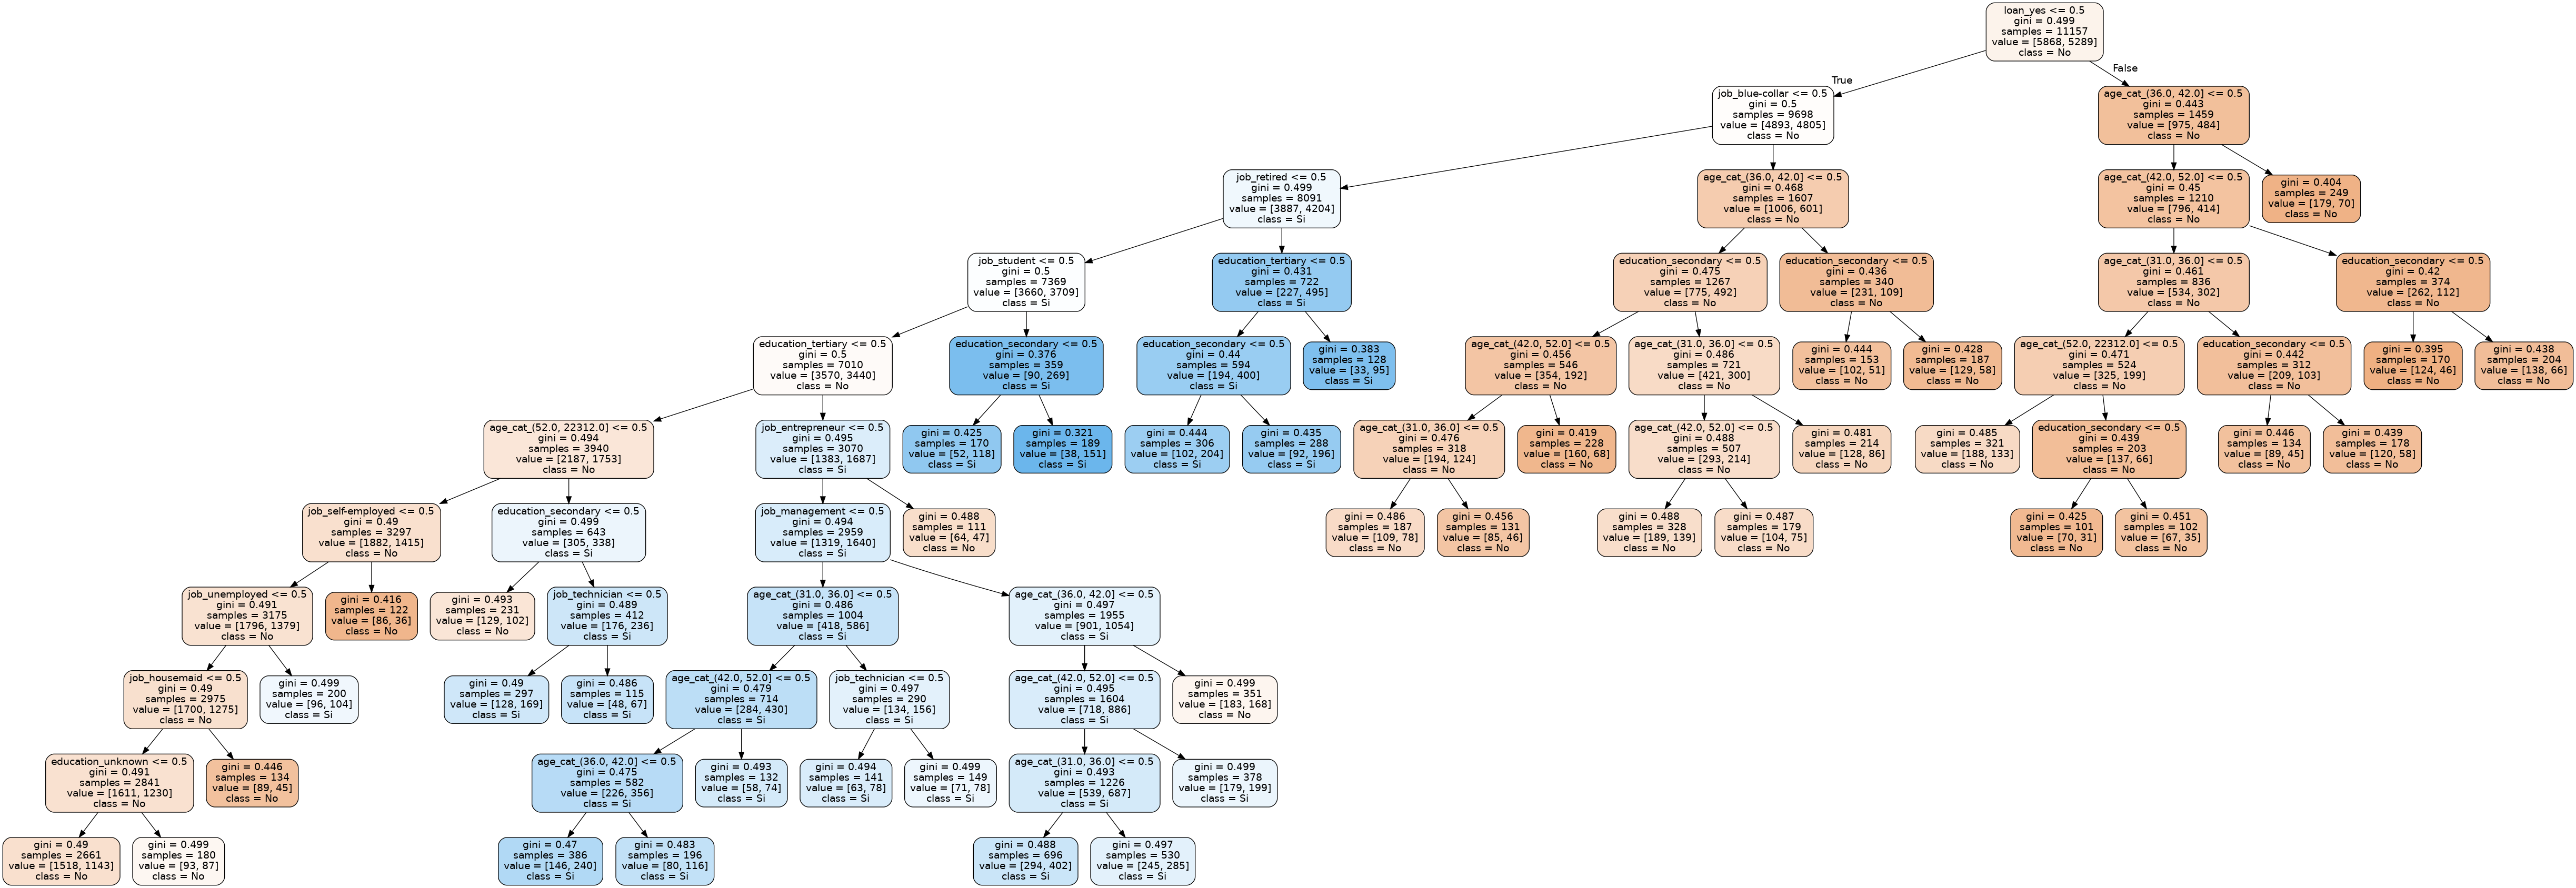

In [194]:
model = tree.DecisionTreeClassifier(
    max_depth= 10,
    min_samples_leaf=100,
    random_state=0) 

model.fit(data_x_final, data_y_final)

def plot_tree(model, data_x):
    dot_data = tree.export_graphviz(model, 
                                    out_file=None, 
                                    feature_names=list(data_x.columns.values), 
                                    class_names=['No', 'Si'], 
                                    rounded=True, 
                                    filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

plot_tree(model, data_x_final)

#### 5) Validamos la tasa de acierto. Consideramos nuevamente el árbol con 3 niveles

Dividimos los datos en TR y TS. Elegimos un tamaño de 20% para los datos de testeo y adoptamos una semilla para reproducir los resultados.

In [199]:
x_tr, x_ts, y_tr, y_ts = train_test_split(data_x_final, data_y_final, test_size=0.2, random_state=0)

In [200]:
TR, TS = pd.concat([x_tr, y_tr], axis=1), pd.concat([x_ts, y_ts], axis=1)

Definimos el modelo y lo entrenamos

In [237]:
model = tree.DecisionTreeClassifier(
    max_depth= 50,
    min_samples_leaf=40,
    min_samples_split=100,
    random_state=0) 

model.fit(x_tr, y_tr)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=40, min_samples_split=100,
                       random_state=0)

Predicción de clase y cálculo del score

In [248]:
pred_tr = model.predict(x_tr)
pred_ts = model.predict(x_ts)

Generamos un dataframe con los y_tr y pred_tr

In [302]:
df_pred_tr = pd.DataFrame(pred_tr, columns=["pred_tr"], index=y_tr.index)

In [303]:
df_val_tr = pd.concat([y_tr, df_pred_tr], axis=1)

In [304]:
df_val_tr.head()

,yes,pred_tr
3081,1,1
10078,0,1
3367,1,1
10445,0,1
8185,0,0


Renombramos la columna "yes" por "y_tr"

In [305]:
df_val_tr.rename(columns = {'yes':'y_tr'}, inplace = True)

In [306]:
df_val_tr.head()

,y_tr,pred_tr
3081,1,1
10078,0,1
3367,1,1
10445,0,1
8185,0,0


Hacemos el mismo procedimiento para las y_ts

In [309]:
df_pred_ts = pd.DataFrame(pred_ts, columns=["pred_ts"], index=y_ts.index)

In [310]:
df_val_ts = pd.concat([y_ts, df_pred_ts], axis=1)

In [311]:
df_val_ts.head()

,yes,pred_ts
4022,1,1
6446,0,0
8045,0,0
9610,0,0
159,1,1


In [312]:
df_val_ts.rename(columns = {'yes':'y_ts'}, inplace = True)

Calculamos el score con las variables de entrenamiento

In [308]:
accuracy_score(df_val_tr.y_tr, df_val_tr.pred_tr, normalize=True)

0.6059383753501401

Repetimos para las variables de testeo

In [313]:
accuracy_score(df_val_ts.y_ts, df_val_ts.pred_ts, normalize=True)

0.6008064516129032

Hay un buen acuerdo entre el score para los datos de entrenamiento y de testeo, sin embargo se puede mejorar la predicción. Una opción es hacer hyperparameter tunning, o cambiar el modelo.